In [1]:
# Install package first
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 24.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/data

/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data


**Kindly Note:**

Don't be scared by how long this file looks like, it's mostly just copy-pasting the model's fit, predict and evaluate functions.

### **READ ME: About Amazon Chronos and AutoGluon:**

**Chronos Github Page**: https://github.com/amazon-science/chronos-forecasting

**AutoGluon Website Page**: https://auto.gluon.ai/stable/tutorials/timeseries/index.html


---

- **AutoGluon-TimeSeries (AG-TS)** includes Chronos family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

  AG-TS provides a **robust and easy** way to use Chronos through the familiar TimeSeriesPredictor API. Rouly speaking, we can:

  1. Use Chronos models in **zero-shot** mode to make forecasts without any dataset-specific training

  2. **Fine-tune** Chronos models on custom data to improve the accuracy
  
  3. **Handle covariates & static features** by combining Chronos with a tabular regression model

---
- **Amazon Chronos**: Chronos is a family of pretrained time series forecasting models based on language model architectures ( [T5 architecture](https://arxiv.org/abs/1910.10683)). The only difference is in the vocabulary size: Chronos-T5 models use 4096 different tokens, compared to 32128 of the original T5 models, resulting in fewer parameters.

  A time series is transformed into a sequence of tokens via **scaling and quantization**, and a language model is trained on these tokens using the **cross-entropy loss**, very similar to how people train a non-time-series LLM model. It uses **TSMixup and KernelSynth** to augment data quality. Once trained, **probabilistic forecasts** are obtained by **sampling multiple future trajectories** given the historical context.
  
  Chronos models have been trained on a large corpus of publicly available time series data (**84B for Chronos**, not sure the size for Chronos-Bolt, assume to be unchanged), as well as synthetic data generated using Gaussian processes.

For details on Chronos models, please refer to the [paper](https://arxiv.org/abs/2403.07815).


- Model, Parameters,  Based on

  chronos-bolt-tiny, 9M,  t5-efficient-tiny

  chronos-bolt-mini, 21M, t5-efficient-mini

  chronos-bolt-small,  48M, t5-efficient-small

  chronos-bolt-base, 205M,  t5-efficient-base

Parameters for other chronos models can be found on its Github page.

---

- **AutoGluon supports both the original Chronos models** (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), as well as the new, more accurate and up to 250x faster Chronos-Bolt⚡ models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)).

The easiest way to get started with Chronos is through the model-specific presets.

- **(recommended)** The new, fast Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.
- The original Chronos models can be accessed using the `"chronos_tiny"`, `"chronos_mini"`, `"chronos_small"`, `"chronos_base"` and `"chronos_large"` presets.

Note that the **original Chronos models of size `small` and above require a GPU to run,** while **all Chronos-Bolt models can be run both on a CPU and a GPU.**

Alternatively, Chronos can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).


# Daily Data:

### Load data

In [21]:
# # individual account usage
# daily_usage = pd.read_csv("daily_usage_individual.csv")
# daily_usage = daily_usage.drop(columns=['Unnamed: 0'], errors='ignore')
# daily_usage['Datetime'] = pd.to_datetime(daily_usage['Datetime'])
# overall usage
daily_overall = pd.read_csv("daily_usage_overall.csv")
daily_overall = daily_overall.drop(columns=['Unnamed: 0'], errors='ignore')
daily_overall['Datetime'] = pd.to_datetime(daily_overall['Datetime'])
daily_overall = daily_overall[:-1] # there is almost no electricity use on the last day compared with previous days

In [6]:
# print(daily_usage.describe())
# print(daily_usage.head())

                            Datetime         Usage
count                         540940  5.409400e+05
mean   2012-12-31 12:00:00.000000256  1.267610e+04
min              2011-01-01 00:00:00  0.000000e+00
25%              2012-01-01 00:00:00  5.713373e+02
50%              2012-12-31 12:00:00  2.537333e+03
75%              2014-01-01 00:00:00  6.711116e+03
max              2015-01-01 00:00:00  2.608175e+06
std                              NaN  6.846121e+04
    Datetime Account  Usage
0 2011-01-01  MT_001    0.0
1 2011-01-02  MT_001    0.0
2 2011-01-03  MT_001    0.0
3 2011-01-04  MT_001    0.0
4 2011-01-05  MT_001    0.0


In [22]:
print(daily_overall.describe())
print(daily_overall.head())

                  Datetime         Usage
count                 1461  1.461000e+03
mean   2012-12-31 00:00:00  4.693345e+06
min    2011-01-01 00:00:00  1.470232e+06
25%    2012-01-01 00:00:00  3.467040e+06
50%    2012-12-31 00:00:00  4.671214e+06
75%    2013-12-31 00:00:00  5.570418e+06
max    2014-12-31 00:00:00  7.542149e+06
std                    NaN  1.261269e+06
    Datetime         Usage
0 2011-01-01  1.713244e+06
1 2011-01-02  2.785336e+06
2 2011-01-03  2.812268e+06
3 2011-01-04  2.866966e+06
4 2011-01-05  2.880437e+06


## Daily Usage Overall

### Modify data to required format

In [23]:
daily_overall['item_id'] = 1
daily_overall = daily_overall.rename(columns={'Datetime': 'timestamp', 'Usage': 'target'})
print(daily_overall.head())

   timestamp        target  item_id
0 2011-01-01  1.713244e+06        1
1 2011-01-02  2.785336e+06        1
2 2011-01-03  2.812268e+06        1
3 2011-01-04  2.866966e+06        1
4 2011-01-05  2.880437e+06        1


In [24]:
daily_overall_data = TimeSeriesDataFrame.from_data_frame(daily_overall)
print(daily_overall_data.head())
daily_overall_data.describe()

                          target
item_id timestamp               
1       2011-01-01  1.713244e+06
        2011-01-02  2.785336e+06
        2011-01-03  2.812268e+06
        2011-01-04  2.866966e+06
        2011-01-05  2.880437e+06


,target
count,1.461000e+03
mean,4.693345e+06
std,1.261269e+06
min,1.470232e+06
25%,3.467040e+06
50%,4.671214e+06
75%,5.570418e+06
max,7.542149e+06


### If we use Chronos bolt_small model:

In [25]:
prediction_length = int(len(daily_overall_data)*0.2)
train_data, test_data = daily_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data/AutogluonModels/ag-20250226_155624'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.48 GB / 12.67 GB (82.7%)
Disk Space Avail:   70.67 GB / 107.72 GB (65.6%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 292,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2

In [26]:
print(train_data.describe())
# print(train_data.head())
print(test_data.describe())
# print(test_data.head())

             target
count  1.169000e+03
mean   4.473570e+06
std    1.262553e+06
min    1.470232e+06
25%    3.161998e+06
50%    4.518524e+06
75%    5.215850e+06
max    7.542149e+06
             target
count  1.461000e+03
mean   4.693345e+06
std    1.261269e+06
min    1.470232e+06
25%    3.467040e+06
50%    4.671214e+06
75%    5.570418e+06
max    7.542149e+06


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


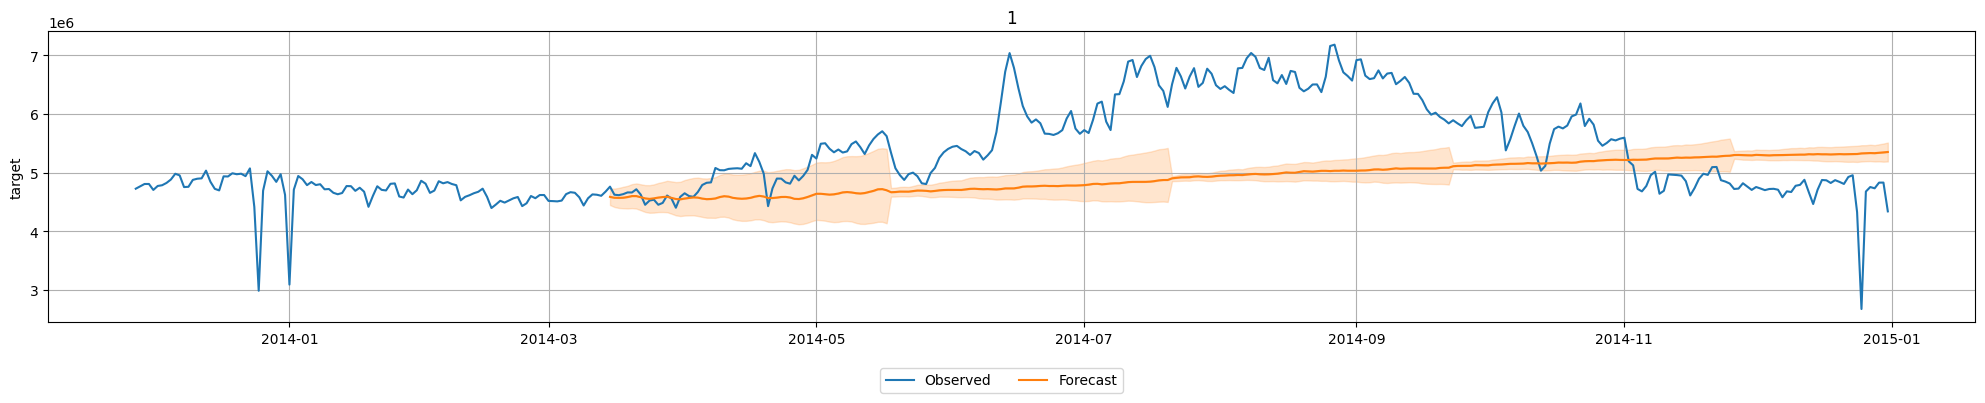

In [27]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=daily_overall_data,
    predictions=predictions,
    item_ids=daily_overall_data.item_ids[:],
    max_history_length=400,
);

In [28]:
print(predictions.shape)
predictions.head()

(292, 10)


mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
1       2014-03-15  4588173.5  4448678.5  4501551.0  4535576.0  4563401.5   
        2014-03-16  4573295.5  4416000.0  4479713.5  4517661.0  4547426.5   
        2014-03-17  4571039.0  4399391.5  4469025.0  4509821.0  4541684.0   
        2014-03-18  4573828.0  4393990.0  4467624.5  4509539.5  4543548.5   
        2014-03-19  4585411.5  4390661.0  4469450.5  4515704.5  4553340.0   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
1       2014-03-15  4588173.5  4614828.5  4643865.0  4678563.5  4731392.0  
        2014-03-16  4573295.5  4601189.5  4634406.0  4673164.0  4729101.0  
        2014-03-17  4571039.0  4602132.0  4636640.5  4677645.0  4741237.5  
        2014-03-18  4573828.0  4606849.5  4644683.0  4689244.0  4759887.5  
        2014-03-19  4585411.5  4618569.0  4658877.5  4704719.5  4776187.5

In [30]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_small],-0.14126,None,3.162585,None,0.009057,1,-0.14126,-851270.3992,-1.067849e+12,-1.033368e+06,-0.144668


### If we use Chronos bolt_base model:

In [31]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data/AutogluonModels/ag-20250226_155701'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.52 GB / 12.67 GB (83.0%)
Disk Space Avail:   70.67 GB / 107.72 GB (65.6%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 292,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


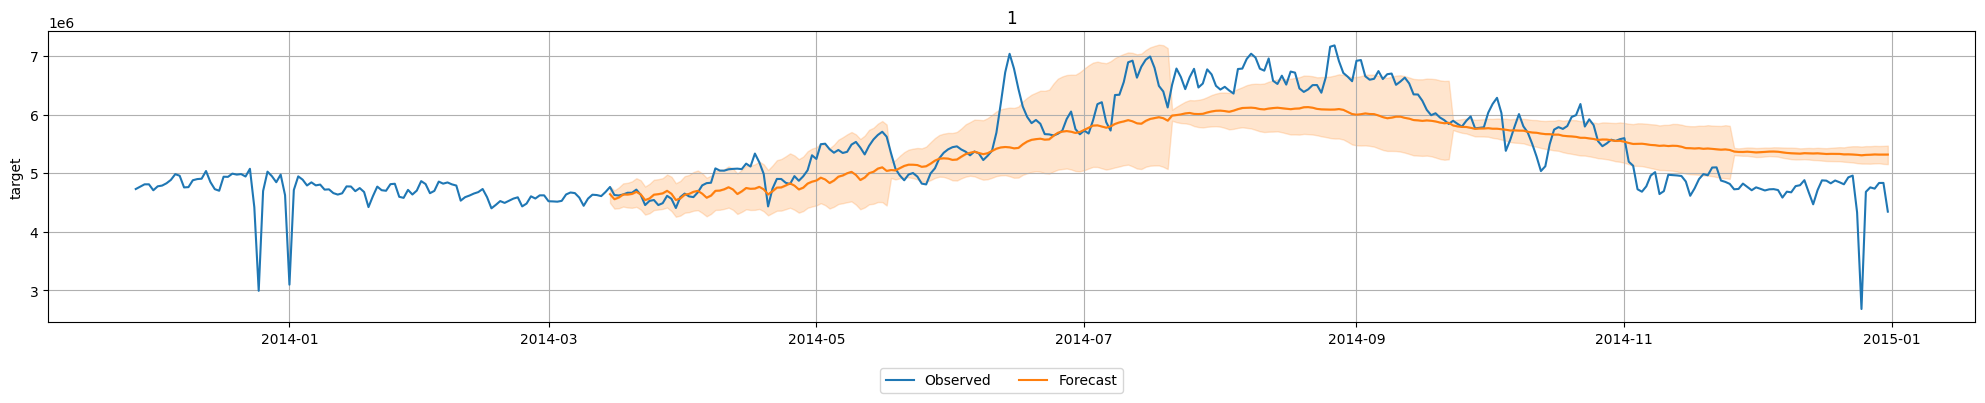

In [32]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=daily_overall_data,
    predictions=predictions,
    item_ids=daily_overall_data.item_ids[:],
    max_history_length=400,
);

In [33]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_base],-0.060007,None,3.579348,None,0.007757,1,-0.060007,-411121.301272,-2.701518e+11,-519761.271285,-0.074539


**Seen from the graph, the bolt_base model captures the trend much better than bolt_small, with MAPE decreasing from 14.47% to 7.45%.**

## Fine tune daily usage overall model

### fine tune bolt_small

In [34]:
# prediction_length = int(len(daily_overall_data)*0.2)
# train_data, test_data = daily_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=120,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data/AutogluonModels/ag-20250226_155939'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.50 GB / 12.67 GB (82.8%)
Disk Space Avail:   70.66 GB / 107.72 GB (65.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 

In [35]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_small],-0.117416,-0.119802,1.591099,0.805079,101.694877,2,-0.117416,-728307.447258,-7.926445e+11,-8.903058e+05,-0.132266
1,ChronosZeroShot[bolt_small],-0.141260,-0.120935,1.592684,1.720096,0.017992,1,-0.141260,-851270.399200,-1.067849e+12,-1.033368e+06,-0.144668


Actual tuning time is around 100s, which can be much faster using GPU. Now let's manually set some hyperparameters to fine tune.

In [36]:
from autogluon.common import space

# prediction_length = int(len(daily_overall_data)*0.2)
# train_data, test_data = daily_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,250,500,1000),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=900,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data/AutogluonModels/ag-20250226_160208'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.67 GB / 12.67 GB (76.3%)
Disk Space Avail:   70.49 GB / 107.72 GB (65.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Ca

In [38]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,WeightedEnsemble,-0.038737,-0.110747,4.999425,1.902496,0.282014,3,-0.038737,-270762.413704,-1.227146e+11,-3.503064e+05,-0.050281,-1.218832
1,ChronosFineTuned[bolt_base]/T1,-0.038737,-0.110747,4.994232,1.902496,373.826566,2,-0.038737,-270762.413704,-1.227146e+11,-3.503064e+05,-0.050281,-1.218832
2,ChronosZeroShot[bolt_small],-0.141260,-0.120935,1.863829,1.661035,0.016773,1,-0.141260,-851270.399200,-1.067849e+12,-1.033368e+06,-0.144668,-3.831976


**The MAPE performance improves to 5.03%!**

### fine tune bolt_base

In [39]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=120,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data/AutogluonModels/ag-20250226_161116'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.63 GB / 12.67 GB (75.9%)
Disk Space Avail:   69.76 GB / 107.72 GB (64.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_base'}]},
 'known_covariates_names': [],
 'nu

In [41]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosZeroShot[bolt_base],-0.060007,-0.132304,3.510941,3.118624,0.015015,1,-0.060007,-411121.301272,-2.701518e+11,-519761.271285,-0.074539


In [42]:
from autogluon.common import space

# prediction_length = int(len(daily_overall_data)*0.2)
# train_data, test_data = daily_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,250,500,1000),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=900,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/.shortcut-targets-by-id/1k-Cfuux6k2QrMQr7UKllzQfyI39rFEKm/data/AutogluonModels/ag-20250226_161452'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       7.06 GB / 12.67 GB (55.7%)
Disk Space Avail:   69.04 GB / 107.72 GB (64.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Cat

In [44]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,WeightedEnsemble,-0.038737,-0.110747,5.440608,1.846587,0.276009,3,-0.038737,-270762.413704,-1.227146e+11,-350306.444094,-0.050281,-1.218832
1,ChronosFineTuned[bolt_base]/T1,-0.038737,-0.110747,5.434714,1.846587,376.488517,2,-0.038737,-270762.413704,-1.227146e+11,-350306.444094,-0.050281,-1.218832
2,ChronosZeroShot[bolt_base],-0.060007,-0.132304,3.693482,3.161387,0.015800,1,-0.060007,-411121.301272,-2.701518e+11,-519761.271285,-0.074539,-1.850654


**The MAPE performance is still 5.03%, same as fine-tuned bolt_small model.**